# Import libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np
import data_prep  #! make sure that the files are in the same folder

# check computation time
import time

# Modelling
from sklearn.ensemble import RandomForestRegressor

# Feature importance
from sklearn.inspection import permutation_importance

# Hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Performance measures
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score,max_error


# Tree Visualisation
import os
from sklearn.tree import export_graphviz

from subprocess import call
from IPython.display import Image

# Prediction visualisation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Has to be last due to overlapping functions from other packages

# Run and import the simulation model with a predefined range of parameters

The parameters are defined in the Snowmeltmodel_variable.py document.
A possible next extention could be to make this more user friendly by asking for inputs such as with the Game_of_Life.py simulation

In [2]:
# Run the model
import Snowmeltmodel_variable

 
 Temperature lapse rate is:  0.001 

..................................................................................................................................................................................... 
 Temperature lapse rate is:  0.002 

..................................................................................................................................................................................... 
 Temperature lapse rate is:  0.003 

..................................................................................................................................................................................... 
 Temperature lapse rate is:  0.005 

..................................................................................................................................................................................... 
 Temperature lapse rate is:  0.004 

.................................................................................

In [11]:
# Assign static features ---- array has length of 1x( all pixels ) x (all simulated versions)
dem = Snowmeltmodel_variable.dem_array

# Assign dynamic features ---- array has length of (timesteps) x ( all pixels ) x (all simulated versions)
snow = Snowmeltmodel_variable.snow_array
precipitation = Snowmeltmodel_variable.precipitation_array
temp = Snowmeltmodel_variable.temp_array
snowfall = Snowmeltmodel_variable.snowfall_array
rainfall = Snowmeltmodel_variable.rainfall_array
actualmelt = Snowmeltmodel_variable.actualmelt_array
runoff = Snowmeltmodel_variable.runoff_array

#Retrieve size of frame and timesteps
horizontal_pixels  = Snowmeltmodel_variable.horizontal_pixels
vertical_pixels = Snowmeltmodel_variable.vertical_pixels
timesteps = Snowmeltmodel_variable.timesteps

# Retrieve the list and the length of the list of variables used to run the different simulations
list_of_variables_for_simulation = Snowmeltmodel_variable.variable_list
number_of_training_simulations = len(list_of_variables_for_simulation)


# Data preparation

In [12]:
# Assign feature of interest to 'data'
data = snow
# Repeat Static drivers for each timestep
dem = np.repeat(dem, timesteps)

### Due to variable rates, multiple simualated trainings.
Cut up arrays for each simulation. Add the new columns, such as neighbours and drivers.
Append all complete simulations to one dataframe for later processing


!! Also for the drivers since we take away the last simulation step because there are no labels to train on this.

In [13]:
list_data = np.array_split(data, number_of_training_simulations)
list_precipitation = np.array_split(precipitation, number_of_training_simulations)
list_temp = np.array_split(temp, number_of_training_simulations)
list_snowfall = np.array_split(snowfall, number_of_training_simulations)
list_rainfall = np.array_split(rainfall, number_of_training_simulations)
list_actualmelt = np.array_split(actualmelt, number_of_training_simulations)
list_runoff = np.array_split(runoff, number_of_training_simulations)
list_dem = np.array_split(dem, number_of_training_simulations)
# create list of drivers and names
list_driver_names = ['precipitation','temp', 'dem']

### Loop over number of training simulations to add:
Neighbours as features
Drivers as features

Results in X number of dataframes. Later append dataframes for training data.
where X = number of training simulations

In [14]:
dfs = [None] * number_of_training_simulations

for iiii in range(number_of_training_simulations):
    print(iiii)
     # Extract the neighbours as features
    # Set the results of the next timestep as labels for each timestep.
    # Remove the last ran timestep of each simulation to avoid NaN's

    dfs[iiii] = data_prep.neighbour_as_feature(data=list_data[iiii],
                                               horizontal_pixels=horizontal_pixels,
                                               vertical_pixels=vertical_pixels,
                                               multiplesteps =False)

    list_drivers = [list_precipitation[iiii],list_temp[iiii], list_dem[iiii]]



     # Add drivers at each timestep and each pixel to the dataframe
    for _ in range(len(list_drivers)):
        driver = list_drivers[_]
        name = list_driver_names[_]

        # Add driver at each timestep and each pixel to the dataframe
        dfs[iiii] = data_prep.driver_as_feature(df=dfs[iiii],
                                         driver=driver, driver_name=name,
                                         horizontal_pixels=horizontal_pixels,
                                         vertical_pixels=vertical_pixels,
                                         multiplesteps=False)

    # Add variable rate as feature
    dfs[iiii] = data_prep.VARIABLE_rate_as_feature(df= dfs[iiii],
                                                   variable_rate=list_of_variables_for_simulation[iiii],
                                                   variable_rate_name='TEMP_rate',
                                                   horizontal_pixels=horizontal_pixels,
                                                   vertical_pixels=vertical_pixels,
                                                   multiplesteps=False)

0
Total number of data points :  216000
Length of one row of pixels, horizontal side of the grid:  30
1
Total number of data points :  216000
Length of one row of pixels, horizontal side of the grid:  30
2
Total number of data points :  216000
Length of one row of pixels, horizontal side of the grid:  30
3
Total number of data points :  216000
Length of one row of pixels, horizontal side of the grid:  30
4
Total number of data points :  216000
Length of one row of pixels, horizontal side of the grid:  30


# Concatenate all dfs

In [15]:
df = pd.concat(dfs)

# Name features and labels
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Extract feature names for later processing
colnames = list(df.columns.values.tolist())
feature_names = colnames[:-1]
label_name = colnames[-1]

## Check data preparation

In [18]:
print(feature_names)
print(features.shape)
print(label_name)
print(labels.shape)
print(number_of_training_simulations*horizontal_pixels*vertical_pixels*timesteps-(number_of_training_simulations*horizontal_pixels*vertical_pixels*2))

if labels.shape[0] == number_of_training_simulations*horizontal_pixels*vertical_pixels*timesteps-(number_of_training_simulations*horizontal_pixels*vertical_pixels*2):
    print('correct')
else:
    print('CHECK DATA PREP')

['x_input', 'left', 'top_left', 'top', 'top_right', 'right', 'bottom_right', 'bottom', 'bottom_left', 'precipitation', 'temp', 'dem', 'TEMP_rate']
(1074000, 13)
y_label
(1074000,)
1074000
corrects


# Split train/test

#### Train on simulations except the last one (made in such a way that the last is the desired one)
#### Test on simulation

In [19]:
length_one_simulation = timesteps*vertical_pixels*horizontal_pixels
one_time_step = horizontal_pixels*vertical_pixels

# Split at last timestep to predict last timestep
X_train = features.iloc[:-(length_one_simulation), :]
y_train = labels.iloc[:-(length_one_simulation)]

# The test set only contains the first initialised values for the simulation. The rest is predicted
X_test = features.iloc[-(length_one_simulation):(-(length_one_simulation)+one_time_step), :]

# Since we want to predict the entire simulation we do not have a set ylabel. Perhaps later construct y_label from all following simulated steps. But time series of important points generates a better view of the performance
y_test =  labels.iloc[-(length_one_simulation)+one_time_step:]

# Check train/test split shapes

In [20]:
print('X_train ', X_train.shape) #training features
print('Y_train ', y_train.shape) #training labels

print('X_test (only 1st step of last simulation)', X_test.shape) #testing features
print('Y_test (multiplestep Y>>X, complete simulation)', y_test.shape) #testing labels

print('Features ', features.shape) #total just to check if testing is really not inside training. shapes add up
print('Labels ', labels.shape)

X_train  (856800, 13)
Y_train  (856800,)
X_test (only 1st step of last simulation) (1200, 13)
Y_test (multiplestep Y>>X, complete simulation) (216000,)
Features  (1074000, 13)
Labels  (1074000,)


# Model optimisation

In [11]:
 # Altogether, there are many possible settings.
# However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 8)]
# Number of features to consider at every split
max_features = [1.0 , 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 200, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [2,4,6]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 80, 150, 220, 290, 360, 430, 500], 'max_features': [1.0, 'sqrt'], 'max_depth': [1, 23, 45, 67, 89, 111, 133, 155, 177, 200], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [4, 8, 16], 'bootstrap': [True, False]}


##### perform hyper parameter optimisation

In [12]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 400 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=4,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [14]:
rf_random.best_params_

# Fit model

In [11]:
rf = RandomForestRegressor(n_estimators =  290,
                           min_samples_split = 2,
                           min_samples_leaf = 4,
                           max_features = 1.0,
                           max_depth =  67,
                           bootstrap = True)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=67, min_samples_leaf=4, n_estimators=290)

# Predict one complete simulation -- add correct driver at each timestep

Remake list_drivers_once to include all drivers just once. Drivers did not change over different simulations


In [ ]:
# list_drivers_once = [list_precipitation[0],list_temp[0],list_snowfall[0],list_rainfall[0],list_actualmelt[0],list_runoff[0], list_dem[0]]
list_drivers_once = [list_precipitation[0],list_temp[0], list_dem[0]]

In [ ]:
# -1 timestep due to removed last timesteps to avoid NaN's in Labels
steps = timesteps-1

# Initialise for saving predictions for animation and performance measures, respectively.
framed_predictions = pd.DataFrame()
array_predictions = np.empty(0)
list_each_prediction = [None] *steps

#Choose the initial starting state of the model as the Test set
X_test_multiple = X_train.iloc[:(horizontal_pixels*vertical_pixels),:]

# - Make predictions
# - Save prediction
# - Set prediction as new input
# - Set neighbours for new input
# - Add static and dynamic drivers to new input
last_pixel_driver = 0
for _ in range(steps):
    print(_)
    # Prediction step
    y_pred_rf = rf.predict(X_test_multiple)

    # Save the solution as a dataframe of pixels
    # For animation
    projected_prediction = pd.DataFrame(np.reshape(y_pred_rf,(int(vertical_pixels),int(horizontal_pixels))))
    framed_predictions = pd.concat([framed_predictions, projected_prediction], axis=0)

    # For MSE map
    list_each_prediction[_] = projected_prediction

    # For performance measures
    array_predictions = np.append(array_predictions, y_pred_rf)


    # Create the new test set for next prediction
    new_state = data_prep.neighbour_as_feature(y_pred_rf.reshape(-1,1),
                                               horizontal_pixels,
                                               vertical_pixels,
                                               multiplesteps=True,
                                               print_true= False)

    # Add the drivers at that timestep
    first_pixel_driver = last_pixel_driver
    last_pixel_driver = first_pixel_driver + (vertical_pixels*horizontal_pixels)
    for __ in range(len(list_drivers_once)):
        driver = list_drivers_once[__]
        name = list_driver_names[__]
        new_state = data_prep.driver_as_feature(df = new_state,
                                                driver=driver[first_pixel_driver:(last_pixel_driver)],
                                                driver_name= name,
                                                horizontal_pixels=horizontal_pixels,
                                                vertical_pixels=vertical_pixels,
                                                multiplesteps=True)

    # Add variable rate as feature
    df = data_prep.VARIABLE_rate_as_feature(df = new_state,
                                            variable_rate= list_of_variables_for_simulation[-1],
                                            variable_rate_name = 'TEMP_rate',
                                            horizontal_pixels=horizontal_pixels,
                                            vertical_pixels=vertical_pixels,
                                            multiplesteps=True)

    # # Check if the driver is added properly
    # colnames = list(df.columns.values.tolist())
    # print(colnames)
    # if _ == 50:
    #     print(new_state)


    # remove the Y_label-- y_label only used for training
    X_test_multiple = new_state.iloc[:, :-1]

# Model performance

### Create an animation of the MSE spread over the map

In [ ]:
# Reshape y_test for MSE. Same shape as framed predictions. vertical x horziontal with next timestep below.
framed_y_test = pd.DataFrame()
first_pixel_y_test = 0
y_test = pd.Series(y_test)
list_y_test_ = [None] * steps

for _ in range(steps):

    last_pixel_y_test = one_time_step*(_+1)
    # print("last pixel = ",last_pixel_y_test)
    # print("first pixel = ", first_pixel_y_test)
    # print('length y_test = ', len(y_test))
    # print('length y_test[i:j] = ', len(y_test[first_pixel_y_test:last_pixel_y_test]))
    projected_y_test = pd.DataFrame(y_test[first_pixel_y_test:last_pixel_y_test].values.reshape((int(vertical_pixels),int(horizontal_pixels))))
    list_y_test_[_] = projected_y_test
    framed_y_test = pd.concat([framed_y_test, projected_y_test], axis=0)

    first_pixel_y_test = last_pixel_y_test

Make list of DF to calc MAE/ MSE over all timeframes. List of dfs calculate per pixel.

In [ ]:
# list_y_test_
squared_difference = [None] * steps
test_concat = pd.DataFrame()
for __ in range(steps):
    # print(__)
    squared_difference[__] = (list_each_prediction[__] - list_y_test_[__])**2

In [ ]:
dfs = squared_difference
MSE_map = pd.concat([each.stack() for each in dfs],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cmap = cm.coolwarm
im = ax.imshow(MSE_map, interpolation='nearest', cmap=cmap, vmin=MSE_map.to_numpy().max(), vmax=MSE_map.to_numpy().min())
ax.set_title('MSE distribution \n  temprate = 0.004')
fig.colorbar(im,cax=cax, orientation='vertical', extend = 'both')#, ticks= [0.05,0.1,0.15,0.2,0.25])

plt.plot()
plt.savefig('_rate004_MSE_map.png')
plt.show()
plt.close()

#### Average error, accuracy. Not a fitting performance measure for these results

In [ ]:
def evaluate(predictions, test_labels):
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

accuracy = evaluate(predictions=array_predictions, test_labels=y_test)

#### MAE, MAPE, explained var

In [ ]:

# Mean absolute percentage error (MAPE) regression loss.
#
# Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2. Furthermore, the output can be arbitrarily high when y_true is small (which is specific to the metric) or when abs(y_true - y_pred) is large (which is common for most regression metrics).


MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred = array_predictions)
MAE = mean_absolute_error(y_true=y_test, y_pred = array_predictions)
MSE = mean_squared_error(y_true=y_test, y_pred = array_predictions)
MAX = max_error(y_true=y_test, y_pred = array_predictions)
EXPL_VAR = explained_variance_score(y_true=y_test, y_pred = array_predictions)

# print('mean absolute percentage: ', MAPE) Too small y_true values for this measure??
print('mean absolute error: ',MAE)
print('mean squared error: ',MSE)
print('MAX ERROR: ',MAX)
print('Explained variance score: ',EXPL_VAR)


# Visualise prediction

### Timeseries of four points of interest

In [ ]:
# Initialise the points
point_1 = []
point_2 = []
point_3 = []
point_4 = []
point_1_pred = []
point_2_pred = []
point_3_pred = []
point_4_pred = []

# Choose the points of interest
point_1_in_array, point_2_in_array, point_3_in_array, point_4_in_array = 139, 261, 755, 863

# Extract the timeseries data of these points from the simulated and emulated data
plot_xvalues = timesteps-2
for x in range(plot_xvalues):
    point_1_in_array += int(vertical_pixels*horizontal_pixels)
    point_2_in_array += int(vertical_pixels*horizontal_pixels)
    point_3_in_array += int(vertical_pixels*horizontal_pixels)
    point_4_in_array += int(vertical_pixels*horizontal_pixels)
    point_1 = np.append(point_1, snow[point_1_in_array+((number_of_training_simulations-1)*length_one_simulation)])
    point_2 = np.append(point_2, snow[point_2_in_array+((number_of_training_simulations-1)*length_one_simulation)])
    point_3 = np.append(point_3, snow[point_3_in_array+((number_of_training_simulations-1)*length_one_simulation)])
    point_4 = np.append(point_4, snow[point_4_in_array+((number_of_training_simulations-1)*length_one_simulation)])
    point_1_pred = np.append(point_1_pred, array_predictions[point_1_in_array])
    point_2_pred = np.append(point_2_pred, array_predictions[point_2_in_array])
    point_3_pred = np.append(point_3_pred, array_predictions[point_3_in_array])
    point_4_pred = np.append(point_4_pred, array_predictions[point_4_in_array])

Plot the timeseries

In [ ]:


fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Emulation performance on several points of the simulation', fontsize=18)

#---- point 1
ax1.plot(range(plot_xvalues), point_1, '.-', color = 'green', linewidth= 2)
ax1.plot(range(plot_xvalues), point_1_pred, '.-', color = 'blue', linewidth= 1.0)

#---- point 2
ax2.plot(range(plot_xvalues), point_2, '.-', color = 'green', linewidth= 2)
ax2.plot(range(plot_xvalues), point_2_pred, '.-', color = 'blue', linewidth= 1.0)

#---- point 3
ax3.plot(range(plot_xvalues), point_3, '.-', color = 'green', linewidth= 2)
ax3.plot(range(plot_xvalues), point_3_pred, '.-', color = 'blue', linewidth= 1.0)

#---- point 4
ax4.plot(range(plot_xvalues), point_4, '.-', color = 'green', linewidth= 2)
ax4.plot(range(plot_xvalues), point_4_pred, '.-', color = 'blue', linewidth= 1.0)

ax1.set_title('First Point', fontsize = 14)
ax1.set_ylabel('Snowfall [m]')
ax1.set_xlabel('Timestep [day]')
ax2.set_title('Second Point', fontsize = 14)
ax2.set_ylabel('Snowfall [m]')
ax2.set_xlabel('Timestep [day]')
ax3.set_title('Third Point', fontsize = 14)
ax3.set_ylabel('Snowfall [m]')
ax3.set_xlabel('Timestep [day]')
ax4.set_title('Fourth Point', fontsize = 14)
ax4.set_ylabel('Snowfall [m]')
ax4.set_xlabel('Timestep [day]')

ax1.legend(['target', 'predicted'])
ax2.legend(['target', 'predicted'])
ax3.legend(['target', 'predicted'])
ax4.legend(['target', 'predicted'])

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

fig.tight_layout()
# plt.subplot_tool()
plt.plot()
plt.savefig('_rate004_timeseries.png')
plt.show()
plt.close()

# Cross correlation plots

Cross correlation plot shows the lags of two time series with each other.

In [ ]:
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Autocorrelation of simulation and emulation on several points', fontsize=18)

#---- point 1
ax1.acorr(point_1, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax1.acorr(point_1_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

#---- point 2
ax2.acorr(point_2, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax2.acorr(point_2_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

#---- point 3
ax3.acorr(point_3, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax3.acorr(point_3_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

#---- point 4
ax4.acorr(point_4, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax4.acorr(point_4_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

ax1.set_title('First Point', fontsize = 14)
ax2.set_title('Second Point', fontsize = 14)
ax3.set_title('Third Point', fontsize = 14)
ax4.set_title('Fourth Point', fontsize = 14)


ax1.legend(['target', 'predicted'] )
ax2.legend(['target', 'predicted'])
ax3.legend(['target', 'predicted'])
ax4.legend(['target', 'predicted'])


plt.plot()
plt.savefig('_rate004_autocorrelation.png')
plt.show()
plt.close()

### Animation of complete predicted simulation

In [ ]:
data_prep.animate_data(framed_predictions, steps, '_rate004_predictions.mp4', vertical_pixels=vertical_pixels)

# Visualise decision

### Feature importance based on decrease in impurity

Elapsed time to compute the importances: 0.634 seconds


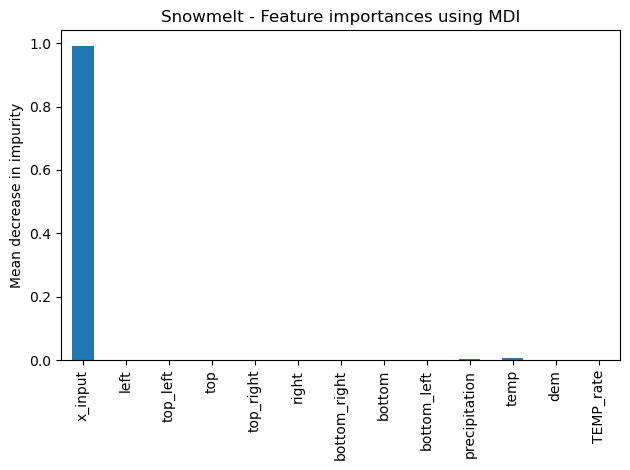

In [13]:



start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run whole script: {elapsed_time:.3f} seconds")



forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Snowmelt - Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.plot()
plt.savefig('Results/Snowmelt_feature_MDI.png')
plt.show()
plt.close()

### Feature importance based on permutations

Elapsed time to compute the importances: 91.374 seconds


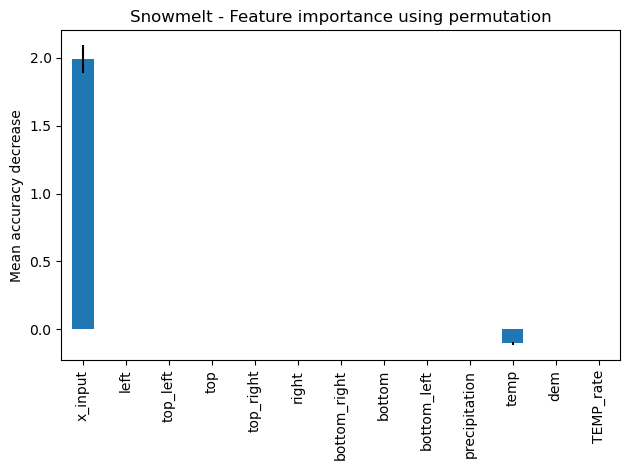

In [14]:

start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test[:one_time_step], n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Snowmelt - Feature importance using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.plot()
plt.savefig('Snowmelt_feature_permutations.png')
plt.show()
plt.close()

In [ ]:
#The following code block represents the visualisation of a tree based model. The random forest predictor as defined above.
tree = rf.estimators_[1]
# tree = rf.estimators_[50]

# # Export as dot file
export_graphviz(tree, out_file='tree.dot',
                feature_names = feature_names ,
                class_names = None,
                rounded = False, proportion = False,
                precision = 3, filled = True)
#
# # Convert to png using system command (requires Graphviz)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'], shell=True, cwd=os.getcwd())
#
# # # # Display in script

Image(filename = 'tree.png')